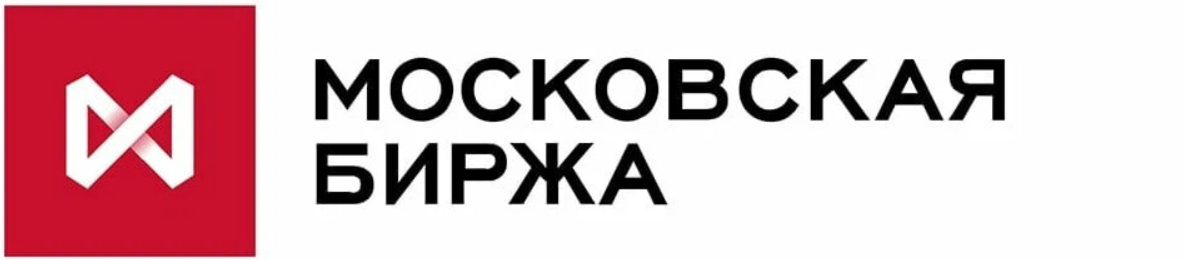

## Цель проекта:
Предсказать стоимость акций Индекса Московской биржи (IMOEX).  


## Немного о данных:  

Данные были взяты с сайта [Московская Биржа | Индексы](https://www.moex.com/ru/index/IMOEX/archive/). В открытом доступе данные доступны за период, равному последним **_10 лет_**.

# PART I

## Задание 1

**<u>Выбрать и обосновать метрику для измерения качества.</u>**

В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи, написав краткое обоснование (1-2 предложения).

_**Критерии оценки**_:

- Предложена метрика - _5б_.

- Присутствует корректное обоснование - _5б_.

[Дополнительный материал о метриках](https://habr.com/ru/company/jetinfosystems/blog/420261/)

Для возможных моделей текущего исследования предлагаю выделить следующие _**ключевые**_ метрики:  
1. **RMSE** - метрика, которая позволяет оценить, насколько точно модель предсказывает целевую переменную. (между MSE и RMSE отдаю предпочтение второй, потому что отслеживание значений в тех же единцах, что и единицы измерения целевой переменной датасета, видится _удобным_). Метрика измеряет среднеквадратичную ошибку между фактическими и предсказанными значениями;
2. **MAPE** - метрика, позволяющая оценить, насколько близко предсказанные значения к фактическим значениям. Чем меньше, тем лучше модель. Метрика позволяет оценить процентную точность модели, измеряя среднюю абсолютную процентную ошибку между фактическими и предсказанными значениями;
3. **R^2** - статистическая мера того, насколько хорошо предсказания регрессии приближаются к реальным точкам данных. Чем больше значение, тем большее соответствие с данными.



Таким образом, метрика _RMSE_ важна для минимизации ошибки предсказания и получения точных числовых значений, метрика _MAPE_ полезна при оценке точности предсказаний в процентном соотношении, метрика _R^2_ имеет значение при оценке объяснительной способности модели.  
<br>
Однако, на мой взгляд, первостепенной метрикой всё же является <u>**R^2**</u>, поскольку ключевая задача модели в результате ее обучения - делать предсказания, максимально приближенные к _реальным_.

## Задание 2

**<u>Провести [EDA](https://moodle.itmo.ru/mod/resource/view.php?id=4771) на своих данных. </u>**

В рамках данного пункта необходимо провести предварительный разведочный анализ своего набора данных.

_**Критерии оценки**_:

- Рассмотрены базовые характеристики/статистики для набора данных - _2б_.

- Реализованы наиболее релевантные визуализации - _4б_.

- По ходу работы присутствуют комментарии (вы, как эксперт в предметной области, можете проинтерпретировать полученные результаты анализа, сделав выводы о том, каким образом лучше работать с набором данных в будущем, какие могут возникнуть проблемы, какую предобработку целесообразно сделать и тп). - _4б_.

In [1]:
!pip install optuna > None

In [2]:
!pip install basemap > None

In [3]:
!pip install skforecast > None

In [4]:
!pip install fedot==0.6.1 > None

In [5]:
!pip install --upgrade matplotlib > None

In [6]:
import json
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from catboost import CatBoostRegressor
from matplotlib.cbook import boxplot_stats
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
path = '/content/IMOEX.csv'
data = pd.read_csv(path, encoding='cp1251', delimiter=';')
data.head()

BOARDID  SECID   TRADEDATE        SHORTNAME             NAME    CLOSE  \
0    SNDX  IMOEX  06.01.2014  Индекс МосБиржи  Индекс МосБиржи  1466,15   
1    SNDX  IMOEX  08.01.2014  Индекс МосБиржи  Индекс МосБиржи  1462,67   
2    SNDX  IMOEX  09.01.2014  Индекс МосБиржи  Индекс МосБиржи  1465,14   
3    SNDX  IMOEX  10.01.2014  Индекс МосБиржи  Индекс МосБиржи  1469,19   
4    SNDX  IMOEX  13.01.2014  Индекс МосБиржи  Индекс МосБиржи  1477,56   

      OPEN     HIGH      LOW        VALUE  DURATION  YIELD  DECIMALS  \
0  1504,14  1504,33  1464,97  16900288729       NaN    NaN         2   
1  1465,99  1470,25  1460,41  16027383642       NaN    NaN         2   
2  1462,67  1470,65  1460,81  20056121954       NaN    NaN         2   
3  1465,74  1470,73  1454,75  29274890126       NaN    NaN         2   
4  1469,19  1482,45  1466,51  29596729994       NaN    NaN         2   

  CAPITALIZATION CURRENCYID     DIVISOR  TRADINGSESSION  VOLUME  
0    6,62517E+12        RUB  4518760150               3     NaN  
1    6,60945E+12        RUB  4518760150               3     NaN  
2    6,62061E+12        RUB  4518760150               3     NaN  
3    6,63894E+12        RUB  4518760150               3     NaN  
4    6,67675E+12        RUB  4518760150               3     NaN

In [8]:
data.tail()

BOARDID  SECID   TRADEDATE        SHORTNAME             NAME    CLOSE  \
2527    SNDX  IMOEX  05.02.2024  Индекс МосБиржи  Индекс МосБиржи  3226,79   
2528    SNDX  IMOEX  06.02.2024  Индекс МосБиржи  Индекс МосБиржи   3238,4   
2529    SNDX  IMOEX  07.02.2024  Индекс МосБиржи  Индекс МосБиржи  3256,58   
2530    SNDX  IMOEX  08.02.2024  Индекс МосБиржи  Индекс МосБиржи  3241,81   
2531    SNDX  IMOEX  09.02.2024  Индекс МосБиржи  Индекс МосБиржи  3242,38   

         OPEN     HIGH      LOW        VALUE  DURATION  YIELD  DECIMALS  \
2527  3218,91  3232,38  3218,91  79772720557       0.0    0.0         2   
2528  3234,44   3238,4  3228,78  47381481665       0.0    0.0         2   
2529  3240,57  3259,24  3240,16  71996364667       0.0    0.0         2   
2530  3261,18  3266,45  3236,79  93017428633       0.0    0.0         2   
2531   3231,3  3242,38  3219,56  49774764900       0.0    0.0         2   

     CAPITALIZATION CURRENCYID     DIVISOR  TRADINGSESSION  VOLUME  
2527    5,71481E+12        RUB  1771049604               3     NaN  
2528    5,73536E+12        RUB  1771049604               3     NaN  
2529    5,76757E+12        RUB  1771049604               3     NaN  
2530     5,7414E+12        RUB  1771049604               3     NaN  
2531    5,74242E+12        RUB  1771049604               3     NaN

In [9]:
data.columns

Index(['BOARDID', 'SECID', 'TRADEDATE', 'SHORTNAME', 'NAME', 'CLOSE', 'OPEN',
       'HIGH', 'LOW', 'VALUE', 'DURATION', 'YIELD', 'DECIMALS',
       'CAPITALIZATION', 'CURRENCYID', 'DIVISOR', 'TRADINGSESSION', 'VOLUME'],
      dtype='object')

In [10]:
data.shape

(2532, 18)

In [11]:
data.dtypes

BOARDID            object
SECID              object
TRADEDATE          object
SHORTNAME          object
NAME               object
CLOSE              object
OPEN               object
HIGH               object
LOW                object
VALUE              object
DURATION          float64
YIELD             float64
DECIMALS            int64
CAPITALIZATION     object
CURRENCYID         object
DIVISOR             int64
TRADINGSESSION      int64
VOLUME            float64
dtype: object

### Предобработка данных

Сделаем обработку данных нашего датасета.  
</br>
Начнем с обозначения чисел: поменяем запятую в них на точку.  
Затем все столбцы с числами, имеющие числовое представление, переформатируем в _числовой_ формат.  
Для даты - сделаем формат _датированным_.   


In [12]:
data = data.replace(',', '.', regex=True)

numeric_columns = ['CLOSE', 'OPEN', 'HIGH', 'LOW', 'VALUE', 'CAPITALIZATION']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)
data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'], format='%d.%m.%Y')

data.head()

BOARDID  SECID  TRADEDATE        SHORTNAME             NAME    CLOSE  \
0    SNDX  IMOEX 2014-01-06  Индекс МосБиржи  Индекс МосБиржи  1466.15   
1    SNDX  IMOEX 2014-01-08  Индекс МосБиржи  Индекс МосБиржи  1462.67   
2    SNDX  IMOEX 2014-01-09  Индекс МосБиржи  Индекс МосБиржи  1465.14   
3    SNDX  IMOEX 2014-01-10  Индекс МосБиржи  Индекс МосБиржи  1469.19   
4    SNDX  IMOEX 2014-01-13  Индекс МосБиржи  Индекс МосБиржи  1477.56   

      OPEN     HIGH      LOW         VALUE  DURATION  YIELD  DECIMALS  \
0  1504.14  1504.33  1464.97  1.690029e+10       NaN    NaN         2   
1  1465.99  1470.25  1460.41  1.602738e+10       NaN    NaN         2   
2  1462.67  1470.65  1460.81  2.005612e+10       NaN    NaN         2   
3  1465.74  1470.73  1454.75  2.927489e+10       NaN    NaN         2   
4  1469.19  1482.45  1466.51  2.959673e+10       NaN    NaN         2   

   CAPITALIZATION CURRENCYID     DIVISOR  TRADINGSESSION  VOLUME  
0    6.625170e+12        RUB  4518760150               3     NaN  
1    6.609450e+12        RUB  4518760150               3     NaN  
2    6.620610e+12        RUB  4518760150               3     NaN  
3    6.638940e+12        RUB  4518760150               3     NaN  
4    6.676750e+12        RUB  4518760150               3     NaN

Рассмотрим подробнее признак `TRADEDATE`.
А именно - какие дни недели у нас имеются в данных

In [13]:
from datetime import datetime


def get_weekday(dates):
    weekdays = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
    res = []
    for date_str in dates:
        date = datetime.strptime(str(date_str), '%Y-%m-%d %H:%M:%S')
        weekday = weekdays[date.weekday()]
        res.append(weekday)
    return res


dates = data.TRADEDATE[:7]
weekdays = get_weekday(dates)
print(weekdays)

['Понедельник', 'Среда', 'Четверг', 'Пятница', 'Понедельник', 'Вторник', 'Среда']


Видим, что среди первых семи строк - имеются пропущенные значения. Если взглянем чуть детальнее, то заметим, что _биржа в выходные и праздники не работает_ (например, 7.02.2014 - вторник, а сб и вс - очевидно, стандартные выходные/нерабочие дни).   
<br>
Целесообразным видится установление непрерывной зависимости от времени - есть потребность в установлении _**ежедневной**_ периодичности временного ряда:  
- для этого установим столбец 'TRADEDATE' как индекс
- переиндексируем временной ряд на ежедневную частоту

In [14]:
data.set_index('TRADEDATE', inplace=True)
data = data.asfreq('D')

In [15]:
data.head(7)

BOARDID  SECID        SHORTNAME             NAME    CLOSE     OPEN  \
TRADEDATE                                                                       
2014-01-06    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1466.15  1504.14   
2014-01-07     NaN    NaN              NaN              NaN      NaN      NaN   
2014-01-08    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1462.67  1465.99   
2014-01-09    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1465.14  1462.67   
2014-01-10    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1469.19  1465.74   
2014-01-11     NaN    NaN              NaN              NaN      NaN      NaN   
2014-01-12     NaN    NaN              NaN              NaN      NaN      NaN   

               HIGH      LOW         VALUE  DURATION  YIELD  DECIMALS  \
TRADEDATE                                                               
2014-01-06  1504.33  1464.97  1.690029e+10       NaN    NaN       2.0   
2014-01-07      NaN      NaN           NaN       NaN    NaN       NaN   
2014-01-08  1470.25  1460.41  1.602738e+10       NaN    NaN       2.0   
2014-01-09  1470.65  1460.81  2.005612e+10       NaN    NaN       2.0   
2014-01-10  1470.73  1454.75  2.927489e+10       NaN    NaN       2.0   
2014-01-11      NaN      NaN           NaN       NaN    NaN       NaN   
2014-01-12      NaN      NaN           NaN       NaN    NaN       NaN   

            CAPITALIZATION CURRENCYID       DIVISOR  TRADINGSESSION  VOLUME  
TRADEDATE                                                                    
2014-01-06    6.625170e+12        RUB  4.518760e+09             3.0     NaN  
2014-01-07             NaN        NaN           NaN             NaN     NaN  
2014-01-08    6.609450e+12        RUB  4.518760e+09             3.0     NaN  
2014-01-09    6.620610e+12        RUB  4.518760e+09             3.0     NaN  
2014-01-10    6.638940e+12        RUB  4.518760e+09             3.0     NaN  
2014-01-11             NaN        NaN           NaN             NaN     NaN  
2014-01-12             NaN        NaN           NaN             NaN     NaN

Как видим, при установлении ежедневной периодичности появляются строки с отсутствующими ранее датами, но без каких-либо значений.  
<br>
Как будем устранять пропуски?  
<br>
Торги в праздники и выходные - закрыты, однако стоимость акций в эти дни не равняется 0, она сохраняет номинал, равный _цене закрытия_ на момент конца работы последнего рабочего дня перед выходным:

- воспользуемся `method='ffill'` для того, чтобы заполнить пустые строки **предыдущими** значениями:

In [16]:
data = data.fillna(method='ffill', axis=0).fillna(0)

In [17]:
data.head(8)

BOARDID  SECID        SHORTNAME             NAME    CLOSE     OPEN  \
TRADEDATE                                                                       
2014-01-06    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1466.15  1504.14   
2014-01-07    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1466.15  1504.14   
2014-01-08    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1462.67  1465.99   
2014-01-09    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1465.14  1462.67   
2014-01-10    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1469.19  1465.74   
2014-01-11    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1469.19  1465.74   
2014-01-12    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1469.19  1465.74   
2014-01-13    SNDX  IMOEX  Индекс МосБиржи  Индекс МосБиржи  1477.56  1469.19   

               HIGH      LOW         VALUE  DURATION  YIELD  DECIMALS  \
TRADEDATE                                                               
2014-01-06  1504.33  1464.97  1.690029e+10       0.0    0.0       2.0   
2014-01-07  1504.33  1464.97  1.690029e+10       0.0    0.0       2.0   
2014-01-08  1470.25  1460.41  1.602738e+10       0.0    0.0       2.0   
2014-01-09  1470.65  1460.81  2.005612e+10       0.0    0.0       2.0   
2014-01-10  1470.73  1454.75  2.927489e+10       0.0    0.0       2.0   
2014-01-11  1470.73  1454.75  2.927489e+10       0.0    0.0       2.0   
2014-01-12  1470.73  1454.75  2.927489e+10       0.0    0.0       2.0   
2014-01-13  1482.45  1466.51  2.959673e+10       0.0    0.0       2.0   

            CAPITALIZATION CURRENCYID       DIVISOR  TRADINGSESSION  VOLUME  
TRADEDATE                                                                    
2014-01-06    6.625170e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-07    6.625170e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-08    6.609450e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-09    6.620610e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-10    6.638940e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-11    6.638940e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-12    6.638940e+12        RUB  4.518760e+09             3.0     0.0  
2014-01-13    6.676750e+12        RUB  4.518760e+09             3.0     0.0

Тут стоит отметить, что были обработаны все данные во всех столбцах/признаках - удостоверимся, что пропущенных значений больше нет:

In [18]:
data.isnull().sum()

BOARDID           0
SECID             0
SHORTNAME         0
NAME              0
CLOSE             0
OPEN              0
HIGH              0
LOW               0
VALUE             0
DURATION          0
YIELD             0
DECIMALS          0
CAPITALIZATION    0
CURRENCYID        0
DIVISOR           0
TRADINGSESSION    0
VOLUME            0
dtype: int64

In [19]:
data.shape

(3687, 17)

А теперь удалим признаки, которые нам **_точно_** не нужны:  
BOARDID, SECID, CURRENCYID, SHORTNAME, NAME, CURRENCYID	- они постоянные, мы рассматриваем только одну котировку акций:

In [20]:
for column in data.columns:
    unique_values = data[column].unique()
    print(f"Уникальные значения в столбце {column}:")
    print(unique_values)
    print(f"Количество уникальных значений: {len(unique_values)}")
    print()

    if len(unique_values) == 1:
        data = data.drop(column, axis=1)

data.head()

Уникальные значения в столбце BOARDID:
['SNDX']
Количество уникальных значений: 1

Уникальные значения в столбце SECID:
['IMOEX']
Количество уникальных значений: 1

Уникальные значения в столбце SHORTNAME:
['Индекс МосБиржи']
Количество уникальных значений: 1

Уникальные значения в столбце NAME:
['Индекс МосБиржи']
Количество уникальных значений: 1

Уникальные значения в столбце CLOSE:
[1466.15 1462.67 1465.14 ... 3256.58 3241.81 3242.38]
Количество уникальных значений: 2506

Уникальные значения в столбце OPEN:
[1504.14 1465.99 1462.67 ... 3240.57 3261.18 3231.3 ]
Количество уникальных значений: 2516

Уникальные значения в столбце HIGH:
[1504.33 1470.25 1470.65 ... 3259.24 3266.45 3242.38]
Количество уникальных значений: 2521

Уникальные значения в столбце LOW:
[1464.97 1460.41 1460.81 ... 3228.78 3240.16 3219.56]
Количество уникальных значений: 2515

Уникальные значения в столбце VALUE:
[1.69002887e+10 1.60273836e+10 2.00561220e+10 ... 7.19963647e+10
 9.30174286e+10 4.97747649e+10]
Ко

CLOSE     OPEN     HIGH      LOW         VALUE  CAPITALIZATION  \
TRADEDATE                                                                      
2014-01-06  1466.15  1504.14  1504.33  1464.97  1.690029e+10    6.625170e+12   
2014-01-07  1466.15  1504.14  1504.33  1464.97  1.690029e+10    6.625170e+12   
2014-01-08  1462.67  1465.99  1470.25  1460.41  1.602738e+10    6.609450e+12   
2014-01-09  1465.14  1462.67  1470.65  1460.81  2.005612e+10    6.620610e+12   
2014-01-10  1469.19  1465.74  1470.73  1454.75  2.927489e+10    6.638940e+12   

                 DIVISOR  
TRADEDATE                 
2014-01-06  4.518760e+09  
2014-01-07  4.518760e+09  
2014-01-08  4.518760e+09  
2014-01-09  4.518760e+09  
2014-01-10  4.518760e+09

Касаемо этих двух признаков:  
```
DURATION and YIELD:

```
-- стоит сказать, что ранее они не использовались для IMOEX, и в какой-то момент `NaN` начали заменять на `0`. Данные столбцы также не несут полезной информации.

Остался еще один признак, который _сомнителен_ по количеству уникальных значений:
```
Уникальные значения в столбце DIVISOR:
[4518760150 4512891870 4508662236 4762945826 4635503383 4697296971
 4685888322 4663700559 4632583222 4689729104 4697009728 4600427694
 4727010744 4687074197 4782605958 4634679117 4596659342 4408925727
 4311697557 4315233488 4277866281 4262826228 4141587958 3949018641
 3708780020 3927791500 3871514068 4042851180 4257839329 4809707787
 5079230866 5077336065 5105497524 5023191120 4944847155 4781494292
 4777848516 4930146741 4872878800 3416313660 1691971867 1745961296
 1771049604]
Количество уникальных значений: 43
```
Его, вместе с признаками VALUE и CAPITALIZATION,	пока оставим для рассмотрения.

Итак, какие признаки у нас остались?

И какой тип данных сейчас у оставшихся признаков:

In [21]:
data.dtypes

CLOSE             float64
OPEN              float64
HIGH              float64
LOW               float64
VALUE             float64
CAPITALIZATION    float64
DIVISOR           float64
dtype: object

### Анализ признаков

Построим матрицу корреляции для наших признаков:

In [22]:
data.reset_index(drop=False, inplace=True)

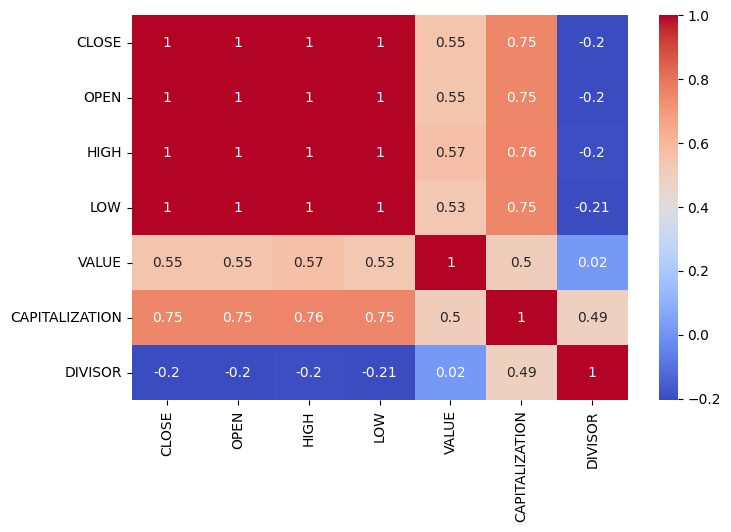

In [23]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Матрица корреляции')
plt.show()

Видим сильную корреляцию основных признаков 'CLOSE', 'OPEN', 'HIGH', 'LOW' - нужно с этим что-то делать.

Добавим **новые** признаки:  
<br>
Первый - разница между ценой открытия и ценой закрытия - _OPEN_CLOSE_DIFF_  
Второй - разница между максимальной и минимальной ценой акций за торговый день - _'PRICE_RANGE'_

In [24]:
data_new = data.copy()

In [25]:
data_new['OPEN_CLOSE_DIFF'] = data['OPEN'] - data['CLOSE']
data_new['PRICE_RANGE'] = data['HIGH'] - data['LOW']

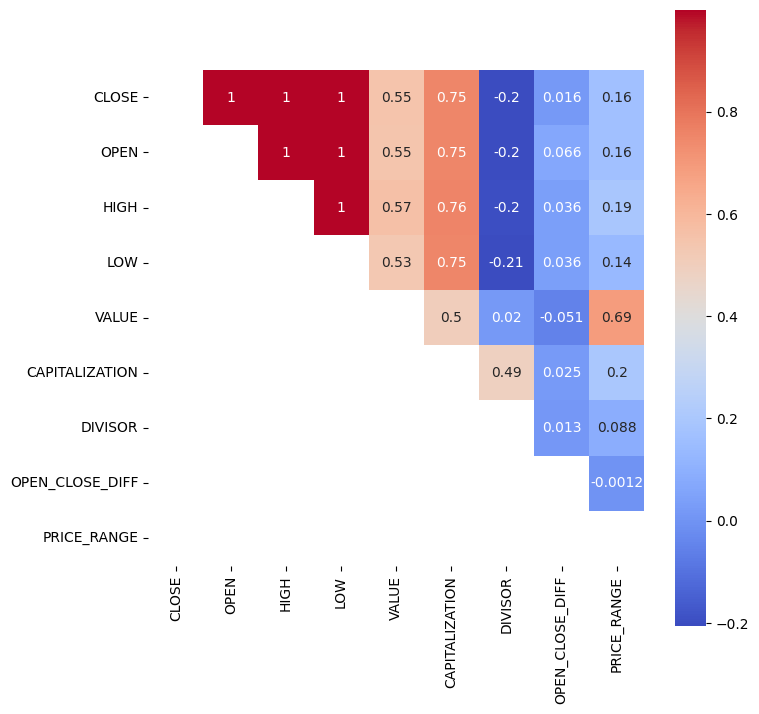

In [26]:
corrs = data_new.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
upper_tri

plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap='coolwarm', square=True, annot=True);

Пока что для рассмотрения уберем только те признаки, что имеют _достоверную_ корреляцию:

In [27]:
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

data_new = data_new.drop(cols_to_drop, axis=1)

data_new.columns

Index(['TRADEDATE', 'CLOSE', 'VALUE', 'CAPITALIZATION', 'DIVISOR',
       'OPEN_CLOSE_DIFF', 'PRICE_RANGE'],
      dtype='object')

Теперь тогда встает вопрос - на каких все же признаках стоит обучать модель?

И посмотрим на еще один вариант визуализации признаков:

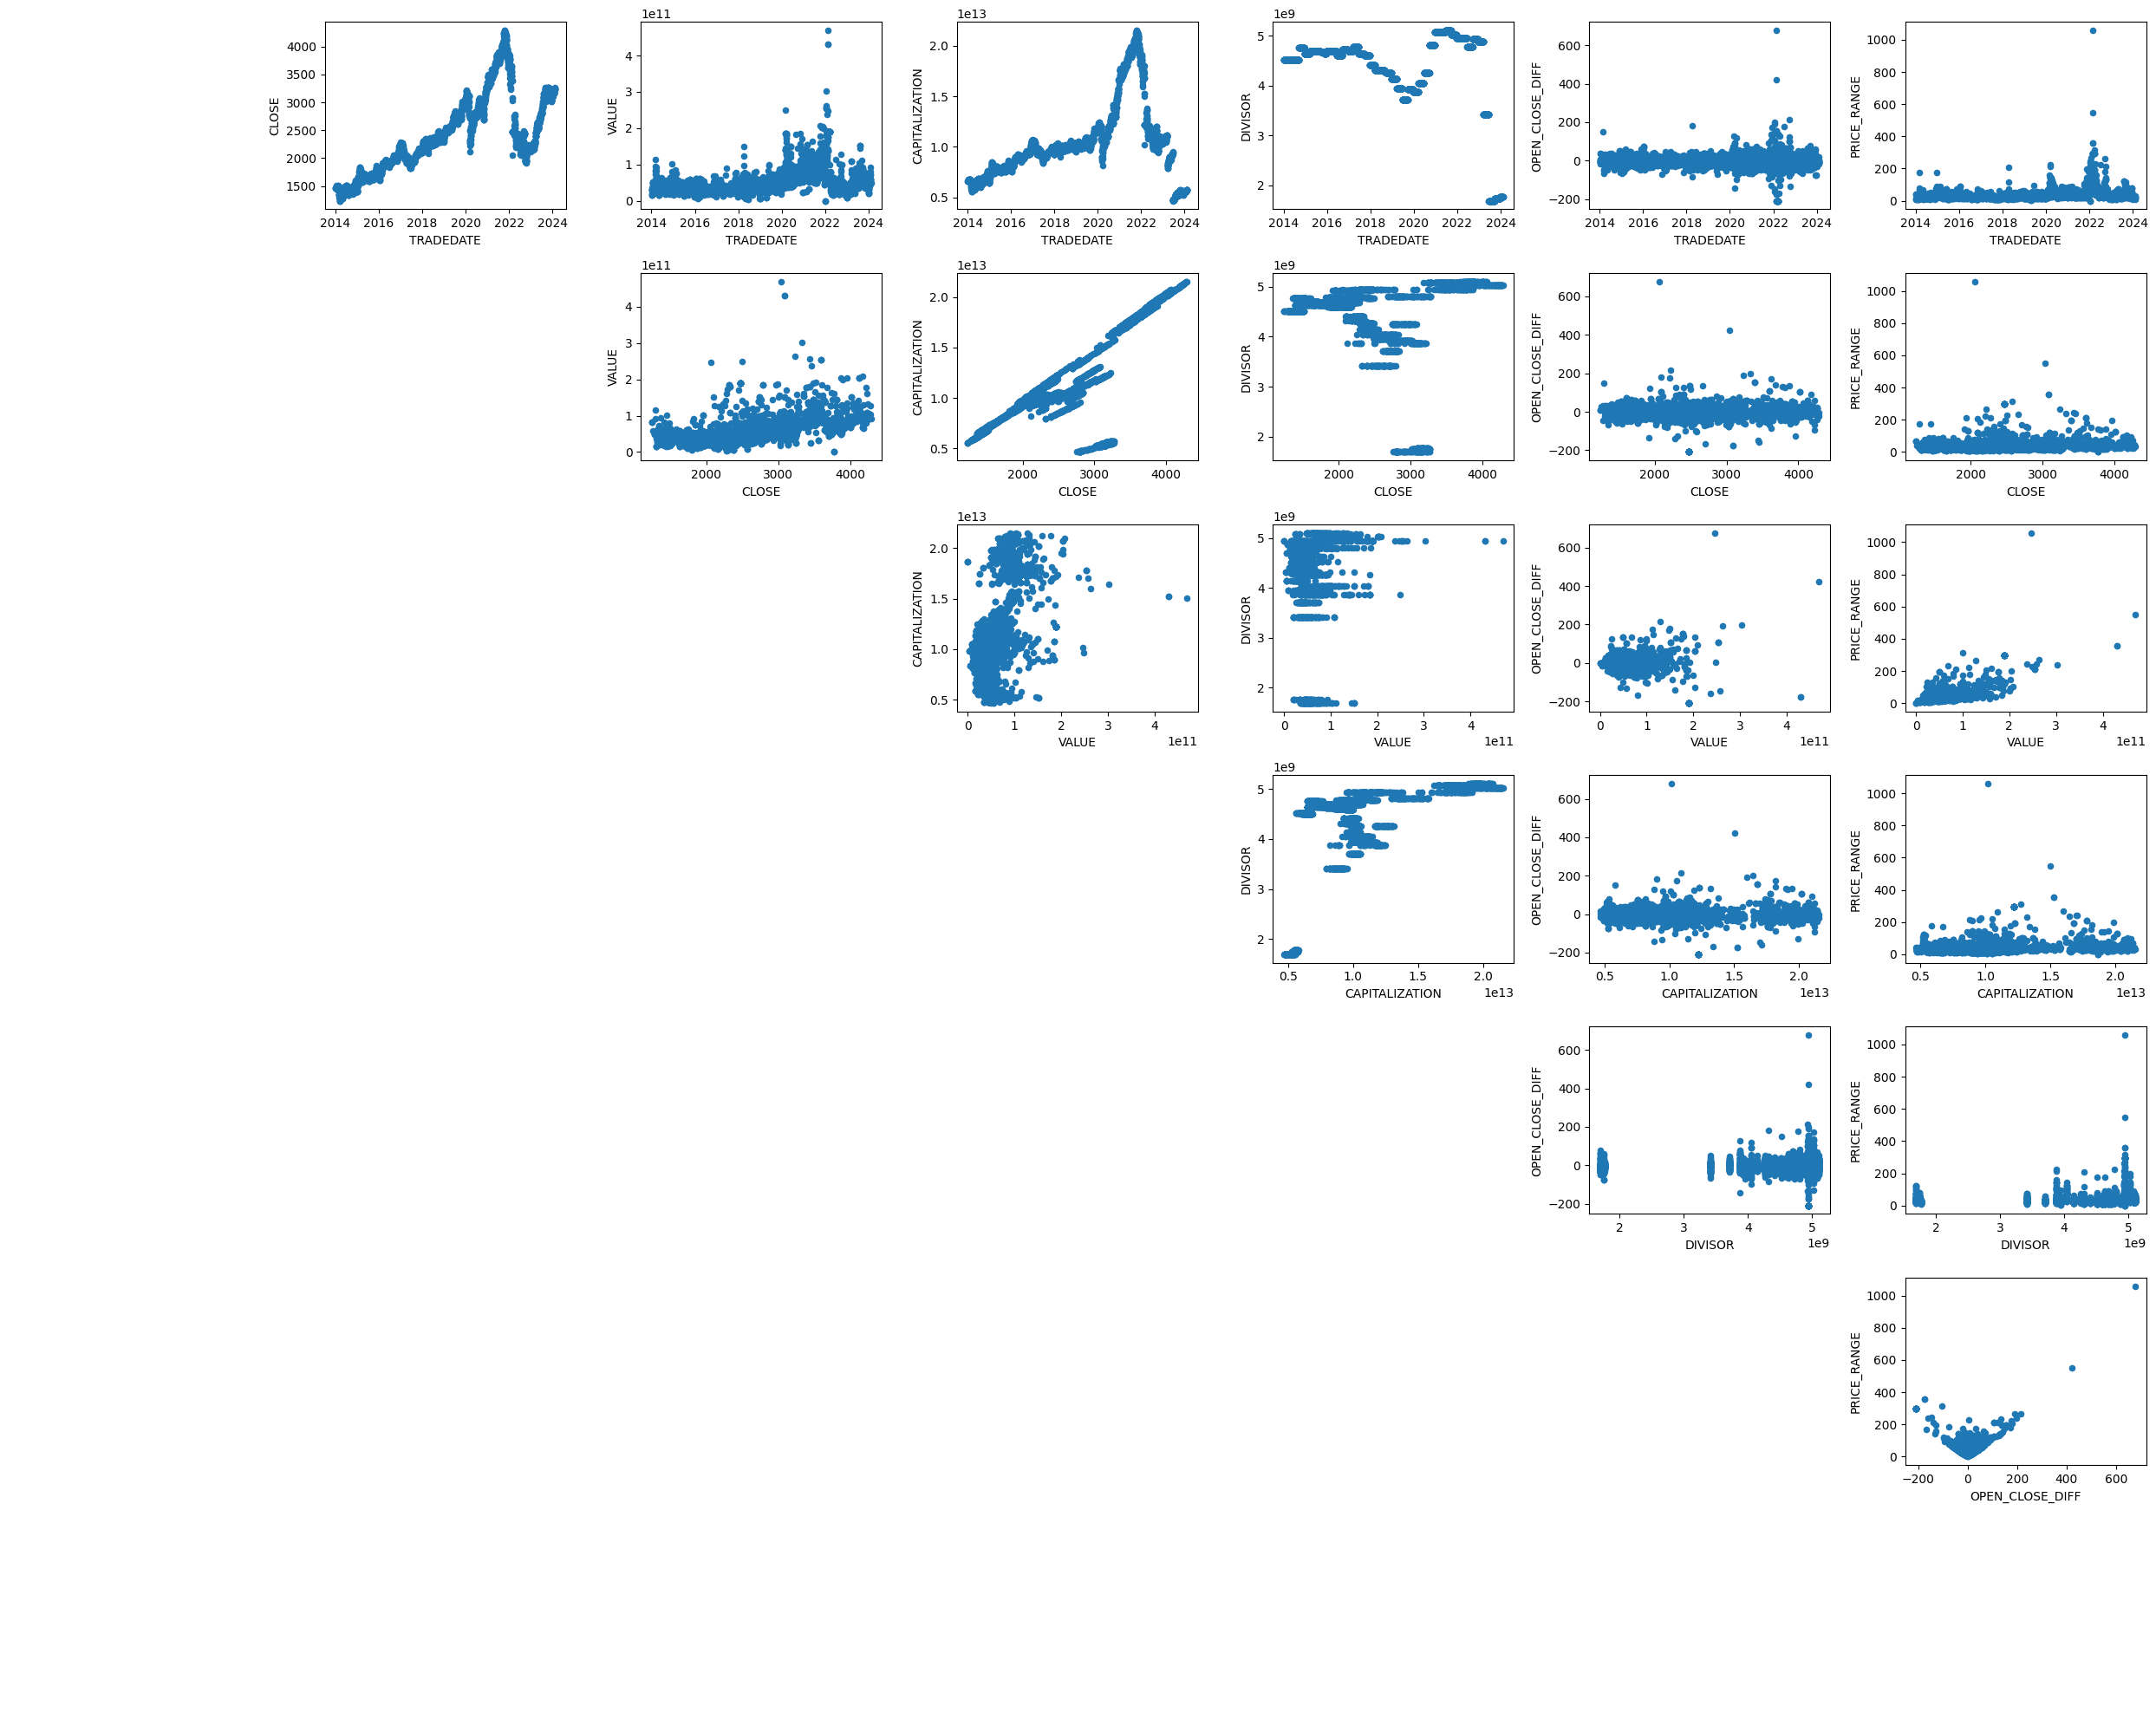

In [28]:
fig, axes = plt.subplots(nrows=len(data_new.columns), ncols=len(data_new.columns), figsize=(25, 20))

for i, feature_1 in enumerate(data_new.columns):
    for j, feature_2 in enumerate(data_new.columns):
        if i >= j:
            axes[i, j].axis('off')
        else:
            data_new.plot.scatter(x=feature_1, y=feature_2, ax=axes[i, j])

plt.tight_layout()
plt.show()

И зафиналим просмотром на возможные выбросы в данных:

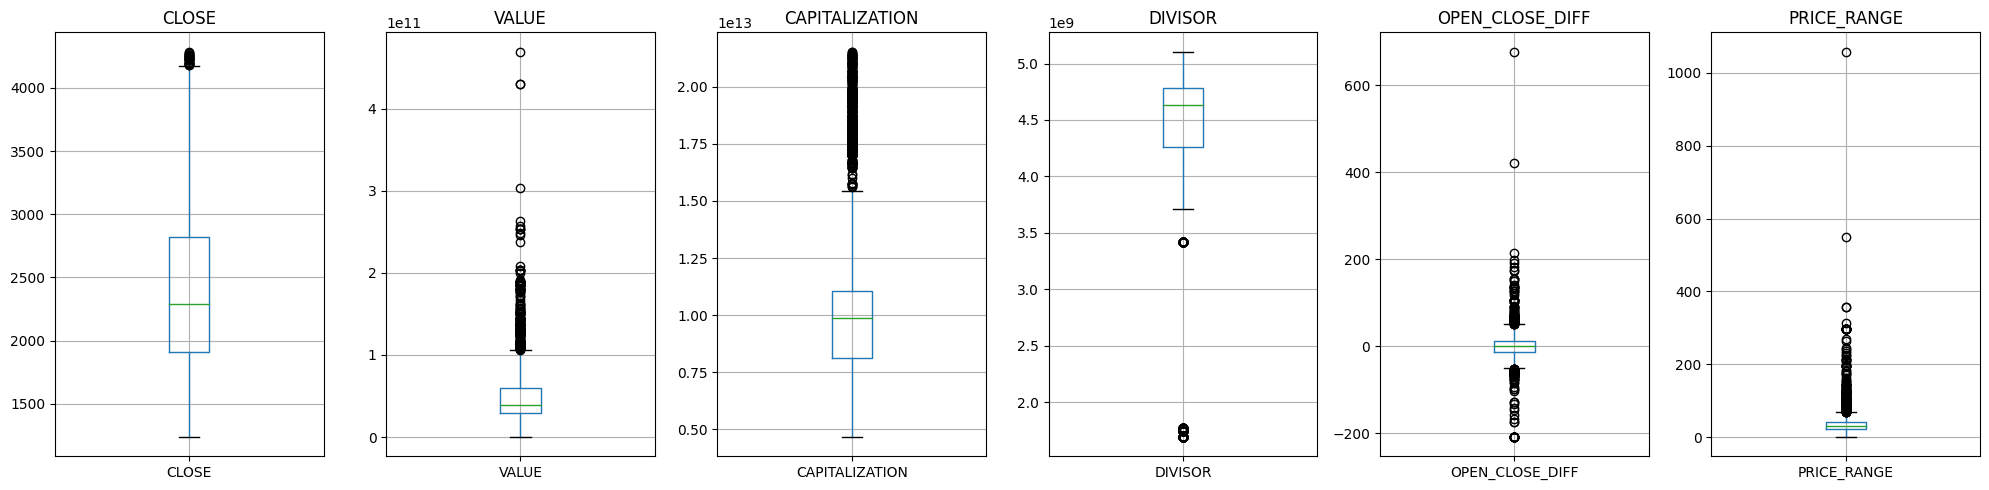

In [29]:
numeric_columns = data_new.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(20, 5))

for i, feature in enumerate(numeric_columns):
    data_new.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

В принципе, как мне кажется, ничего удивительного для цен акций.
Выбросы для них характеры.  А некоторые параметры априори являются специфическими.
<br>
_Их более детальное рассмотрение будет **опущено**._

Теперь посмотрим на распределение численных признаков:

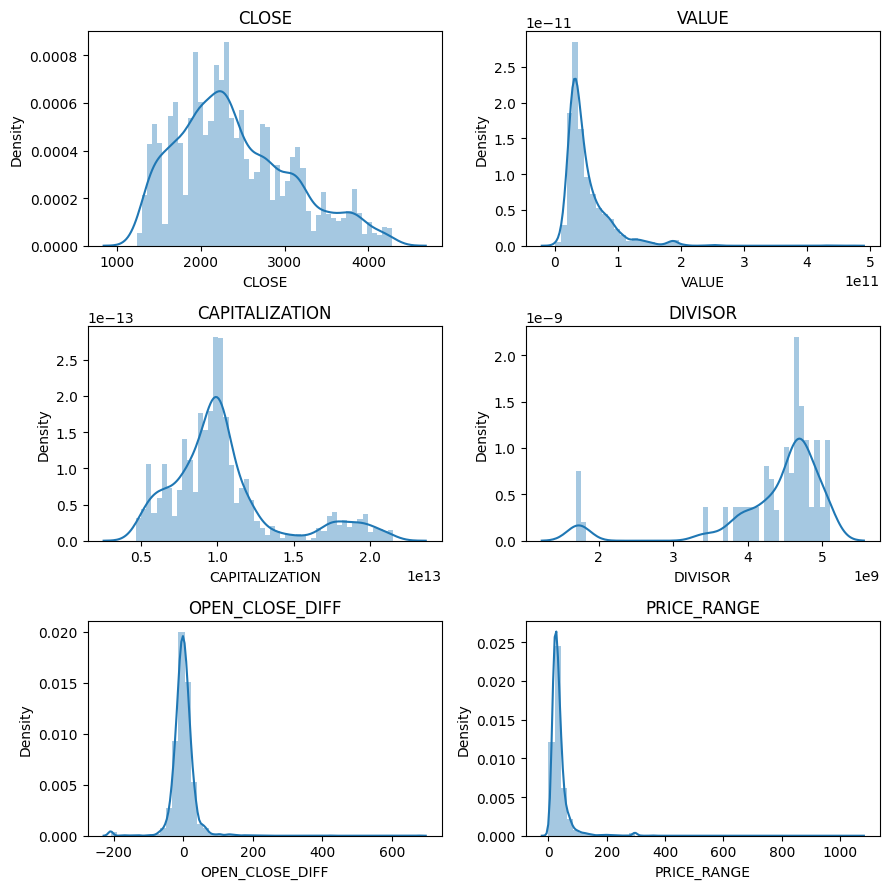

In [30]:
fig, axes = plt.subplots(len(numeric_columns)//2, 2, figsize=(9, 3 * (len(numeric_columns)//2)))

for i, feature in enumerate(data_new.columns[1:]):
    if data_new[feature].dtype in [int, float]:
        row = i // 2
        col = i % 2
        sns.distplot(data_new[feature].dropna(), bins=50, ax=axes[row, col])
        axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

Параметр _DIVISOR_ отличается от нормального распределния - как будто можно делитнуть, без попыток его нормализовать.  
<br>

**ОДНАКО пока просто БУДЕМ ЭТО ИМЕТЬ В ВИДУ**

Напоминают ли текущие распределения нормальное?  
-- Напоминают :)  

### Итоговое представление данных

В терминах фондовой биржи обычно говорят про _линию тренда_ и _волатильность_.

Представим данные цен котировок IMOEX на момент открытия и закрытия торговой сессии в привычном классческом виде и определим линии тренда:

In [31]:
new_data_tr = data['TRADEDATE'].copy()
new_data_tr = data['TRADEDATE'].apply(lambda x: x.toordinal())

trend_open = np.polyfit(new_data_tr, data['OPEN'], 1)
trend_open_line = np.polyval(trend_open, new_data_tr)

trend_close = np.polyfit(new_data_tr, data['CLOSE'], 1)
trend_close_line = np.polyval(trend_close, new_data_tr)

fig = go.Figure()

fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=data['OPEN'], mode='lines', name='OPEN'))
fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=data['CLOSE'], mode='lines', name='CLOSE'))

fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=trend_close_line, mode='lines', name='Trend CLOSE'))
fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=trend_open_line, mode='lines', name='Trend OPEN'))

fig.update_layout(title='График ценообразования на момент открытия и закрытия торговой сессии акций IMOEX. Линии тренда',
                  xaxis_title='Дата', yaxis_title='Цена')

fig.show()

In [32]:
if not os.path.exists('./results/'):
    os.makedirs('./results/')

In [33]:
fig.write_html("./results/classic_IMOEX.html")

In [34]:
data.shape

(3687, 8)

Как видим, главный тренд у акций - _восходящий_.

Построим график волатильности акций в течение периода, равному _260 дням_ (одному году, т.к. в данных отсутвуют сб и вс - выходные):

In [35]:
fig = go.Figure()

data_open_vol = data['OPEN'].rolling(window=90).std()
data_close_vol = data['CLOSE'].rolling(window=90).std()

fig = go.Figure()

fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=data_open_vol, mode='lines', name='Open Volatility'))
fig.add_trace(go.Scatter(x=data['TRADEDATE'], y=data_close_vol, mode='lines', name='Close Volatility'))

fig.update_layout(title='График квартальной волатильности акций IMOEX', xaxis_title='Дата', yaxis_title='Волатильность')

fig.show()

In [36]:
fig.write_html("./results/volatility_IMOEX.html")

Из-за не самой спокойной политическо-экономической ситуации можно сделать вывод, что рынок российских акций весьма неустойчив - об этом свидельствует и график волатильности IMOEX.

В качестве более интерактивного представления данных:

Построим график свечей:

In [37]:
fig = go.Figure(data=[go.Candlestick(x=data['TRADEDATE'],
        open=data["OPEN"],
        high=data["HIGH"],
        low=data["LOW"],
        close=data["CLOSE"])])

fig.update_layout(
    title='Свечной график стоимости акций IMOEX',
    yaxis_title='Цена', xaxis_title='Дата', xaxis_rangeslider_visible=False

)

fig.show()

In [38]:
fig.write_html("./results/candle_IMOEX.html")

🟢 _Зеленые_ свечи указывают на то, что цена закрытия выше или равна цене открытия.  
🔴 _Красные_ свечи указывают на то, что цена закрытия ниже цены открытия.

Добавим "интерактива" - ползунок к графику выше:

In [39]:
fig = go.Figure(
    data=go.Ohlc(
        x=data['TRADEDATE'],
        open=data["OPEN"],
        high=data["HIGH"],
        low=data["LOW"],
        close=data["CLOSE"]
    )
)

fig.update_layout(
    title='График стоимости акций IMOEX',
    yaxis_title='Цена', xaxis_title='Дата'

)
fig.show()

In [40]:
fig.write_html("./results/slider_IMOEX.html")

## Задание 3

**<u>Построить и оценить качество бейзлайна.</u>**

В рамках данного пункта необходимо выбрать и обучить бейзлайн-модель, а также измерить ее качество.

_**Критерии оценки:**_

- Произведено измерение качества константного предсказания (например, наиболее частотный класс для классификации, среднее/медиана для регрессии) - _3б_.

- Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть - _5б_.

- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - _2б_.

_P.S. Предполагается, что участники  продвинутого трека среди прочего продемонстрируют использование библиотеки plotly для визуализации._

### Обучение бейзлайн-модели

In [41]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

In [42]:
data_new.columns

Index(['TRADEDATE', 'CLOSE', 'VALUE', 'CAPITALIZATION', 'DIVISOR',
       'OPEN_CLOSE_DIFF', 'PRICE_RANGE'],
      dtype='object')

Обычно при прогнозировании цен акций, используется информация о ценах акций в прошлом (открытие, максимум, минимум) для предсказания будущих цен закрытия.  
<br>
Разделим наши данные на тренировочную и тестовую выборку в соотношении 0.8 к 0.2. Поскольку наша задача подразумеваем временную зависимость, то использование метода `train_test_split()` будет некорректным - готовим данные вручную:

In [43]:
train_size = int(len(data_new) * 0.8)
train_data = data_new[:train_size]
test_data = data_new[train_size:]

X_train =  train_data.drop('CLOSE', axis=1)
X_test = test_data.drop('CLOSE', axis=1)
y_train = train_data['CLOSE']
y_test = test_data['CLOSE']
X_train.head()

TRADEDATE         VALUE  CAPITALIZATION       DIVISOR  OPEN_CLOSE_DIFF  \
0 2014-01-06  1.690029e+10    6.625170e+12  4.518760e+09            37.99   
1 2014-01-07  1.690029e+10    6.625170e+12  4.518760e+09            37.99   
2 2014-01-08  1.602738e+10    6.609450e+12  4.518760e+09             3.32   
3 2014-01-09  2.005612e+10    6.620610e+12  4.518760e+09            -2.47   
4 2014-01-10  2.927489e+10    6.638940e+12  4.518760e+09            -3.45   

   PRICE_RANGE  
0        39.36  
1        39.36  
2         9.84  
3         9.84  
4        15.98

Рассмотрим три варианта прогноза с разными стратегиями: выбор медианы, среднего, квантиль:

In [44]:
strategies = ['median', 'mean', 'quantile']
metrics = ['RMSE', 'MAPE', 'R^2']

for strategy in strategies:
    dummy = DummyRegressor(strategy=strategy)

    if strategy == 'quantile':
        dummy.quantile = 0.5

    dummy.fit(X_train, y_train)
    y_preds_dummy = dummy.predict(X_test)

    rmse_dummy = np.sqrt(mean_squared_error(y_test, y_preds_dummy))
    mape_dummy = mean_absolute_percentage_error(y_test, y_preds_dummy)
    r2_dummy = r2_score(y_test, y_preds_dummy)

    print(f"Strategy: {strategy}")
    print(f"RMSE константного предсказания: {rmse_dummy}")
    print(f"MAPE константного предсказания: {mape_dummy}")
    print(f"R^2 константного предсказания: {r2_dummy}")
    print()

Strategy: median
RMSE константного предсказания: 571.1401977261556
MAPE константного предсказания: 0.145466034239495
R^2 константного предсказания: -0.7618446462404307

Strategy: mean
RMSE константного предсказания: 499.70161677995867
MAPE константного предсказания: 0.13500009561413628
R^2 константного предсказания: -0.3486636899988307

Strategy: quantile
RMSE константного предсказания: 571.1401977261556
MAPE константного предсказания: 0.145466034239495
R^2 константного предсказания: -0.7618446462404307



Как видим, разница значений метрик у бейзлайновой модели в зависимости от выбранной _стратегии_ незначительная.  
<br>
Качество модели оставляет желать лучшего.  
Параметры _RMSE_, _R^2_ заставляют "содрогаться" от значений, хотя и значение _MAPE_ для цен акций - немало.

#### Визуализация результатов

Построим график для _одной_ из стратегий (т.к. они похожи друг на друга).

In [45]:
dummy_med = DummyRegressor(strategy='median')
dummy_med.fit(X_train, y_train)
y_preds_dummy_med = dummy_med.predict(X_test)

In [46]:
def plot_model_results(actual, predicted, title):
    results = pd.DataFrame({'True': actual, 'Prediction': predicted})
    sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
    d_line= np.arange(results.min().min(), results.max().max())
    plt.plot(d_line, d_line, color='red', linestyle='--')
    plt.title = title
    plt.grid()
    plt.show()

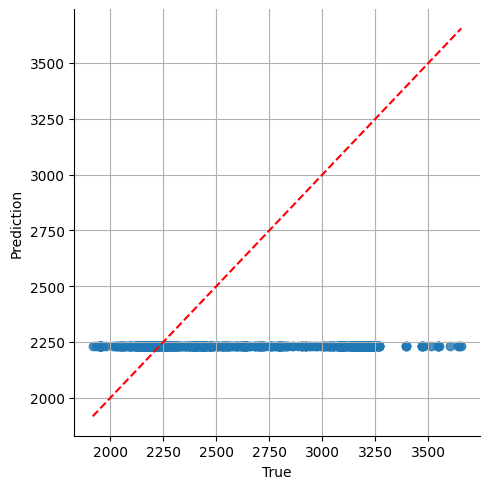

In [47]:
plot_model_results(y_test, y_preds_dummy_med, title='Dummy')

In [48]:
def plot_metrics(constants, metric_values, metric_name):
    metric_name = str(metric_name)
    plt.figure(figsize=(5, 3))
    plt.plot(constants, metric_values)
    plt.xlabel('Constant')
    plt.ylabel(metric_name)
    plt.title = metric_name
    plt.grid(True)
    plt.show()

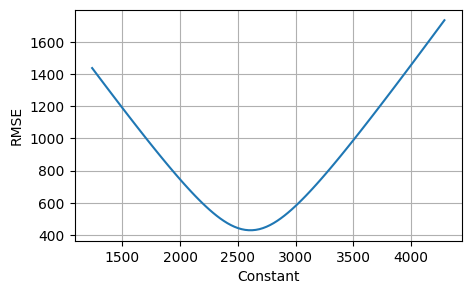

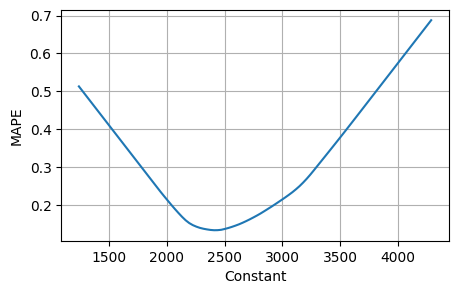

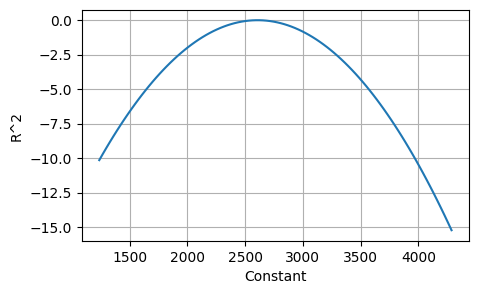

In [49]:
constants = np.linspace(y_train.min(), y_train.max(), num=100)
rmse_values = []
mape_values = []
r2_values = []

for constant in constants:
    y_preds_constant = np.full_like(y_test, constant)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds_constant))
    mape = mean_absolute_percentage_error(y_test, y_preds_constant)
    r2 = r2_score(y_test, y_preds_constant)
    rmse_values.append(rmse)
    mape_values.append(mape)
    r2_values.append(r2)

plot_metrics(constants, rmse_values, 'RMSE')
plot_metrics(constants, mape_values, 'MAPE')
plot_metrics(constants, r2_values, 'R^2')

### Обучение модели линейной регрессии

Для обучения модели линейной регрессии необходимо что-то сделать с признаком - `TRADEDATE`.

Решаем проблемы с помощью _лейбл-кодирования_:

In [50]:
data_new.columns

Index(['TRADEDATE', 'CLOSE', 'VALUE', 'CAPITALIZATION', 'DIVISOR',
       'OPEN_CLOSE_DIFF', 'PRICE_RANGE'],
      dtype='object')

In [51]:
label_encoder = LabelEncoder()

data_new['TRADEDATE'] = label_encoder.fit_transform(data_new['TRADEDATE'])

train_size = int(len(data_new) * 0.8)
train_data = data_new[:train_size]
test_data = data_new[train_size:]

X_train =  train_data.drop(['CLOSE'], axis=1)
X_test = test_data.drop(['CLOSE'], axis=1)
y_train = train_data['CLOSE']
y_test = test_data['CLOSE']

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

In [53]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_preds_lr))
print("RMSE константного предсказания:", rmse_lr)

mape_lr = mean_absolute_percentage_error(y_test, y_preds_lr)
print("MAPE константного предсказания:", mape_lr)

r2_lr = r2_score(y_test, y_preds_lr)
print("R^2 константного предсказания:", r2_lr)

RMSE константного предсказания: 106.83585346839462
MAPE константного предсказания: 0.02648214210592705
R^2 константного предсказания: 0.9383523957784995


Посмотрим, какие признаки являются важными и решающими при обучении модели линейной регрессии:

In [54]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(8, 4))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

<Axes: >

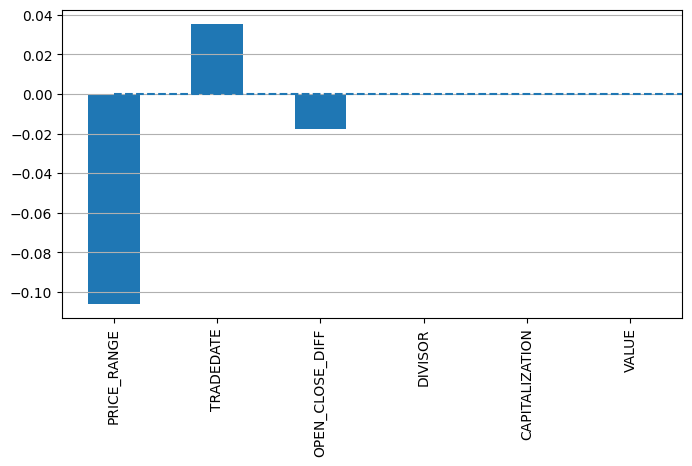

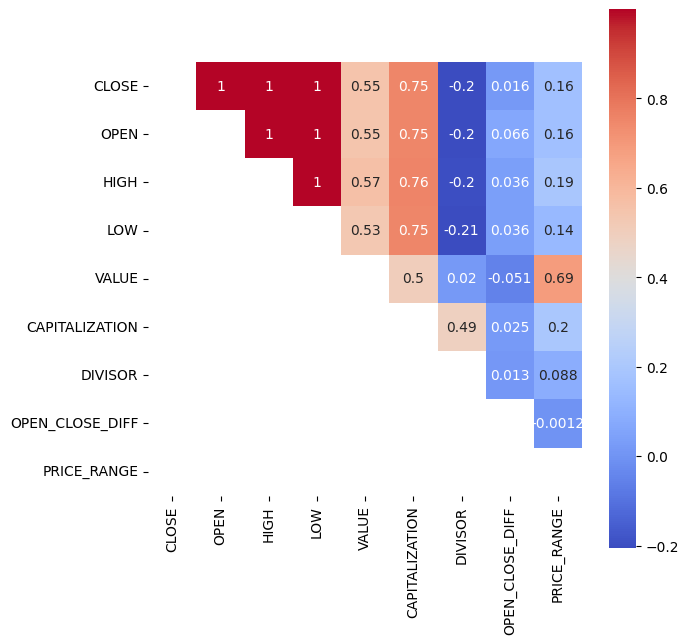

In [55]:
plotCoefficients(lr, X_train.columns)

# И еще раз вспомним, как коррелируют признаки:
plt.figure(figsize=(7, 7))
sns.heatmap(upper_tri, cmap='coolwarm', square=True, annot=True)

#### Визуализация результатов

Посмотрим, график качества модели линейной регрессии (зависимость предсказанных ею значений от истинных (реальных)):

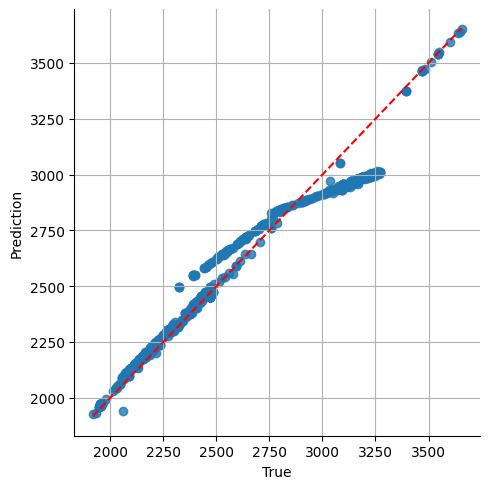

In [56]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

In [57]:
decoded_feature = label_encoder.inverse_transform(data_new['TRADEDATE'])

trace_train = go.Scatter(
    x=decoded_feature[:len(train_data)],
    y=train_data['CLOSE'],
    mode='lines',
    name='Тренировочные данные'
)

trace_real = go.Scatter(
    x=decoded_feature[len(train_data):],
    y=test_data['CLOSE'],
    mode='lines',
    name='Реальные значения'
)

trace_pred = go.Scatter(
    x=decoded_feature[len(train_data):],
    y=y_preds_lr,
    mode='lines',
    name='Предсказанные значения'
)

data_trace = [trace_train, trace_real, trace_pred]

layout = go.Layout(
    title='Сравнение тренировочных, реальных и предсказанных значений',
    xaxis=dict(title='Дата'),
    yaxis=dict(title='Стоимость акций на момент закрытия')
)

fig = go.Figure(data=data_trace, layout=layout)
fig.show()

In [58]:
fig.write_html("./results/result_lr_IMOEX.html")

### Дополнительное

Рассмотрим, влияет ли нормализация на качество и результат модели линейной регрессии?

In [59]:
from sklearn.preprocessing import StandardScaler

Создаем копию исходного тренировочного и тестового датафреймов и нормализуем все столбцы, кроме первого:


In [60]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled.iloc[:, 1:] = scaler.fit_transform(X_train.iloc[:, 1:])

In [61]:
X_test_scaled = X_test.copy()
X_test_scaled.iloc[:, 1:] = scaler.transform(X_test.iloc[:, 1:])

In [62]:
X_train_scaled.head(3)

TRADEDATE     VALUE  CAPITALIZATION   DIVISOR  OPEN_CLOSE_DIFF  PRICE_RANGE
0          0 -1.027959       -1.091138 -0.026039         1.554627     0.281372
1          1 -1.027959       -1.091138 -0.026039         1.554627     0.281372
2          2 -1.055068       -1.095358 -0.026039         0.121090    -1.039965

In [63]:
X_test_scaled.head(3)

TRADEDATE     VALUE  CAPITALIZATION   DIVISOR  OPEN_CLOSE_DIFF  \
2949       2949  1.891189        1.834637  1.166578         1.268498   
2950       2950  1.643082        1.738234  1.166578         1.124194   
2951       2951  2.328678        1.737992  1.166578         1.154378   

      PRICE_RANGE  
2949     1.386514  
2950     1.768323  
2951     2.645634

In [64]:
lr_new = LinearRegression()
lr_new.fit(X_train_scaled, y_train)
y_preds_lr_new = lr_new.predict(X_test_scaled)

In [65]:
rmse_lr_new = np.sqrt(mean_squared_error(y_test, y_preds_lr_new))
print("RMSE константного предсказания:", rmse_lr_new )

mape_lr_new = mean_absolute_percentage_error(y_test, y_preds_lr_new)
print("MAPE константного предсказания:", mape_lr_new )

r2_lr_new = r2_score(y_test, y_preds_lr_new)
print("R^2 константного предсказания:", r2_lr_new )

RMSE константного предсказания: 106.83585346823823
MAPE константного предсказания: 0.026482142105979347
R^2 константного предсказания: 0.9383523957786799


In [66]:
print(rmse_lr, rmse_lr_new)
print(mape_lr, mape_lr_new)
print(r2_lr, r2_lr_new, "\n")

print("Раньше было лучше" if r2_lr > r2_lr_new else "После нормализации стало лучше")

106.83585346839462 106.83585346823823
0.02648214210592705 0.026482142105979347
0.9383523957784995 0.9383523957786799 

После нормализации стало лучше


Но разницы практически нет.

# PART II

## Задание 1

**<u>Построить более сложную модель с подбором гиперпараметров </u>**– _10б_.

В рамках данной точки необходимо использовать более сложную модель для решения задачи,  оптимизировать гиперпараметры и оценить ее качество.

**<u>_Критерии оценки:_</u>**

- Выбрана более сложная ML-модель - _1б_.

- Произведен подбор гиперпараметров с использованием кросс-валидации - _4б_.

- Выбранная модель обучена с лучшими подобранными значениями гиперпараметров - _4б_.

- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - _1б_.

<br>


_Предполагается, что участники продвинулись в этом направлении среди представленных возможностей  использования библиотеки для выбора  гиперпараметров._

**ПРО ПОСТАНОВКУ ЗАДАЧИ.**  
Наиболее валидной постановкой задачи будет: "предсказание цены закрытия в день _n_ по ценам открытия или в дни _n - 1_, _n - 2_ и т.д. То есть, предсказывание будущей цены актива, так как в данных есть довольно сильная автокорреляция. Такая задача является задачей прогнозирования временного ряда, в специфику которой входит генерация признаков и валидация особого вида.

**ЧТО БУДЕМ ДЕЛАТЬ?**   
В данном случае можно сгенерировать признаки из таргета, на основе которых вы сможете обучить модель. В качестве простого варианта для генерации можно рассмотреть так называемые "лаги" - сдвиги таргета, например, имея в качестве признаков показатели "цена три дня назад", "цена два дня назад", "цена вчера" предсказываем цену сегодня и т.п. В дальнейшем эту логику можно усложнять, используя скользящие статистики, моделирование отдельных компонент временного ряда и т.п.  
<br>
Рассмотрение начнем с обучения только на предыдущих данных целевого признака, добавляя постепенно новые признаки.

Ранее при рассмотрении модели линейной регрессии мы даты закодировали лейбл-энкодером. Теперь декодируем эти данные:

In [67]:
data_new.TRADEDATE = label_encoder.inverse_transform(data_new['TRADEDATE'])

In [68]:
data_new.head(5)

TRADEDATE    CLOSE         VALUE  CAPITALIZATION       DIVISOR  \
0 2014-01-06  1466.15  1.690029e+10    6.625170e+12  4.518760e+09   
1 2014-01-07  1466.15  1.690029e+10    6.625170e+12  4.518760e+09   
2 2014-01-08  1462.67  1.602738e+10    6.609450e+12  4.518760e+09   
3 2014-01-09  1465.14  2.005612e+10    6.620610e+12  4.518760e+09   
4 2014-01-10  1469.19  2.927489e+10    6.638940e+12  4.518760e+09   

   OPEN_CLOSE_DIFF  PRICE_RANGE  
0            37.99        39.36  
1            37.99        39.36  
2             3.32         9.84  
3            -2.47         9.84  
4            -3.45        15.98

In [69]:
data_new.shape

(3687, 7)

Далее работаем с данными как с временным рядом.  

In [70]:
data_new['TRADEDATE'] = pd.to_datetime(data_new['TRADEDATE'])
data_new.set_index('TRADEDATE', inplace=True)

### Тест Дики-Фуллера

Проведем _**тест Дики-Фуллера**_, который помогает определить, является ли временной ряд стационарным. Стационарность означает, что статистические свойства ряда (среднее, дисперсия, автокорреляция) остаются постоянными со временем. Стационарные временные ряды облегчают прогнозирование и анализ, поскольку они имеют более предсказуемые и устойчивые характеристики.   
<br>

Проверим, какие из признаков являются стационарными:

In [71]:
data_diff = data_new.copy()

for column in data_new.columns:
    ts = data_new[column]
    result = adfuller(ts)

    print(f'Results of Dickey-Fuller Test for {column}:')
    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('\n')

    # Дифференцирование признака, если он нестационарный
    if result[1] > 0.05:
        print(f'{column} is not stationary. Differencing...')
        data_diff = data_diff.drop(column, axis=1)
        data_diff[f'{column}_diff'] = abs(ts.diff())

        # Повторный тест Дики-Фуллера после дифференцирования
        result_diff = adfuller(data_diff[f'{column}_diff'].dropna())
        print(f'Results of Dickey-Fuller Test for {column} after differencing:')
        print('Test Statistic:', result_diff[0])
        print('p-value:', result_diff[1])
        print('Critical Values:')
        for key, value in result_diff[4].items():
            print(f'\t{key}: {value}')

    if result_diff[1] <= 0.05:
        print('Признак стационарен! :)')
        print('\n')

Results of Dickey-Fuller Test for CLOSE:
Test Statistic: -1.408683464333842
p-value: 0.5781061492870118
Critical Values:
	1%: -3.4321325874394772
	5%: -2.862327648143656
	10%: -2.5671892768146547


CLOSE is not stationary. Differencing...
Results of Dickey-Fuller Test for CLOSE after differencing:
Test Statistic: -6.290835565337835
p-value: 3.602721314630698e-08
Critical Values:
	1%: -3.432140396322538
	5%: -2.862331097513094
	10%: -2.5671911131426133
Признак стационарен! :)


Results of Dickey-Fuller Test for VALUE:
Test Statistic: -4.308204615423737
p-value: 0.000429902375500061
Critical Values:
	1%: -3.4321399062635227
	5%: -2.862330881042633
	10%: -2.5671909979009953


Признак стационарен! :)


Results of Dickey-Fuller Test for CAPITALIZATION:
Test Statistic: -1.3392847676329727
p-value: 0.6110134406513541
Critical Values:
	1%: -3.432129676641202
	5%: -2.8623263623724924
	10%: -2.567188592313841


CAPITALIZATION is not stationary. Differencing...
Results of Dickey-Fuller Test for C


Рассмотрим интерперетацию результатов теста Дики-Фуллера:

1. **Test Statistic (Тестовая статистика)**: Чем более отрицательное значение тестовой статистики, тем более уверенно можно отвергнуть нулевую гипотезу о нестационарности временного ряда.

2. **p-value (p-значение)**: P-значение представляет вероятность получить такие или более экстремальные результаты, если нулевая гипотеза верна.

3. **Critical Values (Критические значения)**: Критические значения представляют собой пороговые значения, при которых отвергается нулевая гипотеза. Значение _Test Statistic_ должно быть меньше этих критических.

<br>

Рассмотрим парочку признаков и их результаты тестов:   
1. **CLOSE**:
  - **Test Statistic**: -1.408683464333842
   - **p-value**: 0.5781061492870118
   - **Интерпретация**: Тестовая статистика близка к критическим значениям, а p-значение значительно больше уровня значимости 0.05. Это говорит о том, что у нас нет достаточных доказательств для отвержения нулевой гипотезы о нестационарности временного ряда CLOSE.  

2. **OPEN_CLOSE_DIFF**:
   - **Test Statistic**: -10.452377814718401
   - **p-value**: 1.4271608921346507e-18
   - **Интерпретация**: Тестовая статистика значительно меньше критических значений, а p-значение сильно меньше уровня значимости 0.05. Это говорит о том, что у нас есть достаточные доказательства для отвержения нулевой гипотезы о нестационарности временного ряда OPEN_CLOSE_DIFF. Таким образом, OPEN_CLOSE_DIFF является стационарным временным рядом.  

То есть имеем: признак CLOSE не являлся изначально стационарным, поэтому его продифференцировали - и о чудо! он стал стационарным.  Признак OPEN_CLOSE_DIFF - сразу же был стационарным.

In [72]:
data_diff = data_diff.fillna(method='ffill', axis=0).fillna(0)
data_diff.isnull().sum()

VALUE                  0
OPEN_CLOSE_DIFF        0
PRICE_RANGE            0
CLOSE_diff             0
CAPITALIZATION_diff    0
DIVISOR_diff           0
dtype: int64

In [73]:
data_diff.reset_index(inplace=True)
data_diff.head(3)

TRADEDATE         VALUE  OPEN_CLOSE_DIFF  PRICE_RANGE  CLOSE_diff  \
0 2014-01-06  1.690029e+10            37.99        39.36        0.00   
1 2014-01-07  1.690029e+10            37.99        39.36        0.00   
2 2014-01-08  1.602738e+10             3.32         9.84        3.48   

   CAPITALIZATION_diff  DIVISOR_diff  
0         0.000000e+00           0.0  
1         0.000000e+00           0.0  
2         1.572000e+10           0.0

### Skforecast. Подбор гиперпараметров

Попробуем рассмотреть простую модель для обучения на временных данных.  
Обычно дифференцирование к данным применяется для стабилизации дисперсии и устранения тренда, а логарифмирование - для сглаживания данных и приведения их к более нормальному распределению. Поэтому далее это и будет проделано с целевым признаком - ценой закрытия:

In [74]:
df = data_diff[['TRADEDATE', 'CLOSE_diff']]
df = df.rename(columns={'TRADEDATE': 'datetime', 'CLOSE_diff': 'y'})

Пропуски заполняем предыдущими значениями, если заполнить предыдущими невозможно - заполняем грядущим - это очень грубая _прикидка_, но давайте посмотрим, что у нас получится:

In [75]:
df['y'] = np.log(df['y'])
df['y'] = df['y'].replace(-np.inf, np.nan)
df['y'] = df['y'].fillna(method='ffill')
df['y'] = df['y'].fillna(method='bfill')
df.head(3)

datetime         y
0 2014-01-06  1.247032
1 2014-01-07  1.247032
2 2014-01-08  1.247032

In [76]:
df.isnull().any()

datetime    False
y           False
dtype: bool

Пропущенных значений нет.  
<br>
Устанавливаем дневную периодичность и индексируем датированный признак, затем организовываем hold-out валидацию. Для упрощенных расчетов для анализа _взята четверть данных_:

In [77]:
data_df = df
data_df = data_df.set_index('datetime').asfreq('D').y

Размер тренировочной выборки: 559
Размер валидационной выборки: 184
Размер тестовой выборки: 184


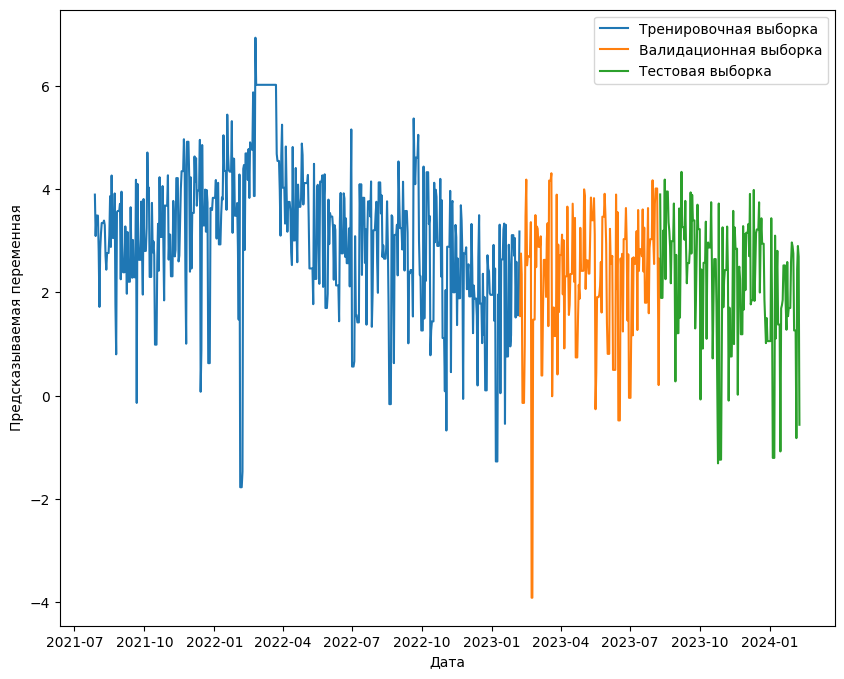

In [78]:
test_size = int(0.05 * len(df.y))
val_size = int(0.05 * len(df.y))

train = df.y[test_size*15:-test_size - val_size]
val = df.y[-test_size - val_size:-test_size]
test = df.y[-test_size:]

print("Размер тренировочной выборки:", len(train))
print("Размер валидационной выборки:", len(val))
print("Размер тестовой выборки:", len(test))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data_df.reset_index().datetime[test_size*15:-test_size - val_size][::-1], train[::-1], label='Тренировочная выборка')
ax.plot(data_df.reset_index().datetime[-test_size - val_size:-test_size][::-1], val[::-1], label='Валидационная выборка')
ax.plot(data_df.reset_index().datetime[-test_size:][::-1], test[::-1], label='Тестовая выборка')
ax.set_xlabel('Дата')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

In [79]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [80]:
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)

linear_forecaster.fit(train)

predictions = linear_forecaster.predict(len(val))

print(f"MAPE = {mean_absolute_percentage_error(val, predictions)}")
print(f"MAE = {mean_absolute_error(val, predictions)}")
print(f"MSE = {mean_squared_error(val, predictions)}")
print(f"R^2 = {r2_score(val, predictions)}")

MAPE = 4.141761518098883
MAE = 1.0555434353774888
MSE = 2.24900925105602
R^2 = -0.3181640423485681


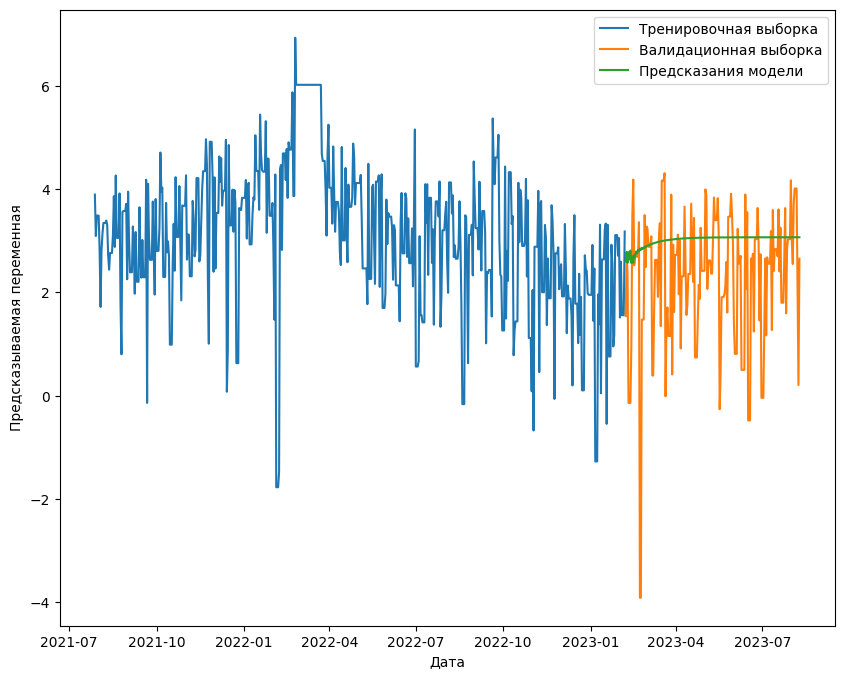

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data_df.reset_index().datetime[test_size*15:-test_size - val_size][::-1], train[::-1], label='Тренировочная выборка')
ax.plot(data_df.reset_index().datetime[-test_size - val_size:-test_size][::-1], val[::-1], label='Валидационная выборка')
ax.plot(data_df.reset_index().datetime[-test_size - val_size:-test_size:], predictions, label='Предсказания модели')
ax.set_xlabel('Дата')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

Посмотрим на каждый признак, используемый моделью `linear_forecaster` для прогнозирования временного ряда:

In [82]:
linear_forecaster.get_feature_importances()

feature  importance
0    lag_1    0.430669
1    lag_2    0.132645
2    lag_3    0.040966
3    lag_4    0.041112
4    lag_5    0.045486
5    lag_6    0.051621
6    lag_7   -0.069908
7    lag_8    0.070765
8    lag_9   -0.032051
9   lag_10    0.089366
10  lag_11   -0.006668
11  lag_12    0.039903

Данная библиотека совместима с многими моделями, в том числе и с CatBoostRegressor:

In [83]:
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=2024, verbose=False),
    lags=12
)
catboost_forecaster.fit(train)
predictions = catboost_forecaster.predict(len(val))

print(f"MAPE = {mean_absolute_percentage_error(val, predictions)}")
print(f"MAE = {mean_absolute_error(val, predictions)}")
print(f"MSE = {mean_squared_error(val, predictions)}")
print(f"R^2 = {r2_score(val, predictions)}")

MAPE = 2.8646202415960587
MAE = 1.1474259352038834
MSE = 2.2628562986006773
R^2 = -0.3262799183315095


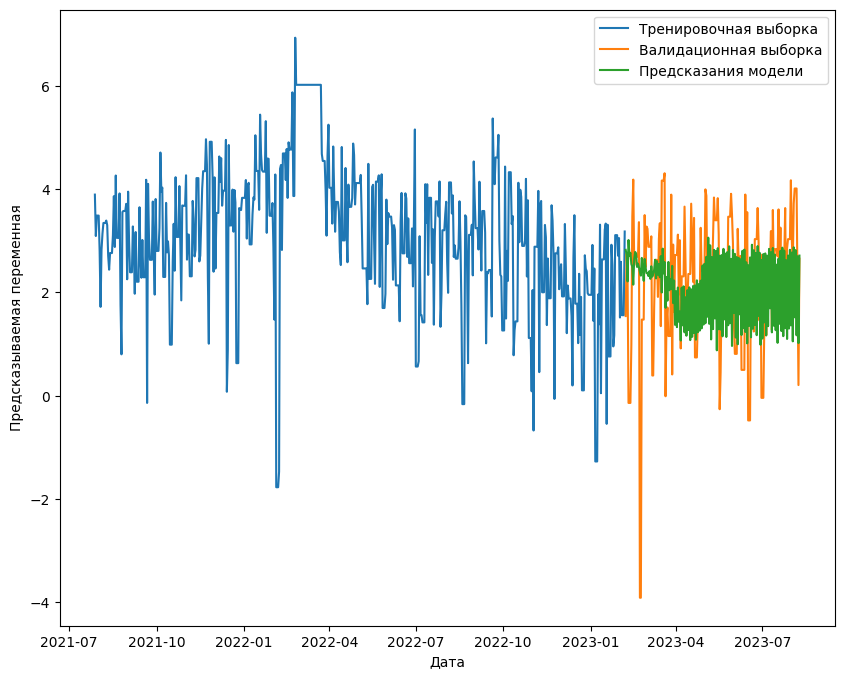

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data_df.reset_index().datetime[test_size*15:-test_size - val_size][::-1], train[::-1], label='Тренировочная выборка')
ax.plot(data_df.reset_index().datetime[-test_size - val_size:-test_size][::-1], val[::-1], label='Валидационная выборка')
ax.plot(data_df.reset_index().datetime[-test_size - val_size:-test_size:], predictions, label='Предсказания модели')
ax.set_xlabel('Дата')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

Создаем модель. И попробуем подобрать лучшие гиперпараметры.

Рассмотрим используемые параметры:
- forecaster - модель
- y - данные на которых мы хотим учиться
- param_grid, lags_grid - параметры, которые мы хотим подбирать
- steps - горизонт предсказания
- initial_train_size - тренировочные данные

- _возвращаемое значение_ - DataFrame с прогнозом

In [85]:
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=2024, verbose=False),
    lags=1
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = data_df.iloc[test_size:],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(train),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = True,
                   show_progress      = True
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 559
Number of observations used for backtesting: 2944
    Number of folds: 16
    Number of steps per fold: 184
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2014-07-09 00:00:00 -- 2016-01-18 00:00:00  (n=559)
    Validation: 2016-01-19 00:00:00 -- 2016-07-20 00:00:00  (n=184)
Fold: 1
    Training:   2014-07-09 00:00:00 -- 2016-01-18 00:00:00  (n=559)
    Validation: 2016-07-21 00:00:00 -- 2017-01-20 00:00:00  (n=184)
Fold: 2
    Training:   2014-07-09 00:00:00 -- 2016-01-18 00:00:00  (n=559)
    Validation: 2017-01-21 00:00:00 -- 2017-07-23 00:00:00  (n=184)
Fold: 3
    Training:   2014-07-09 00:00:00 -- 2016-01-18 00:00:00  (n=559)
    Validation: 2017-07-24 00:00:00 -- 2018-01-23 00:00:00  (n=184)
Fold: 4
    Training:   2014-07-09 00:00:00 -- 2016-01-18 00:00:00  (n=559)
    Validation: 2018-01-24 00:00

In [86]:
best_params = results_grid.iloc[0]

print("Лучшие параметры:")
print(f"n_estimators: {best_params}")

Лучшие параметры:
n_estimators: index                                                                  14
lags                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
params                             {'max_depth': 10, 'n_estimators': 200}
mean_absolute_percentage_error                                   1.191313
max_depth                                                              10
n_estimators                                                          200
Name: 0, dtype: object


In [87]:
parameters = {
    'best_n_estimators': results_grid.iloc[0]['params']['n_estimators'],
    'best_max_depth': results_grid.iloc[0]['params']['max_depth'],
    'best_lags': best_params['lags'].tolist()
}

file_path = './results/best_parameters.json'
with open(file_path, 'w') as file:
    json.dump(parameters, file, indent=4)

print(f"Параметры сохранены в файл: {file_path}")

Параметры сохранены в файл: ./results/best_parameters.json


Теперь обучим линейную регрессию и catboost на всех обучающих данных и протестируем модели:

In [88]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=2024, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1
)

param_grid = {
    'model__n_estimators': results_grid.iloc[0]['params']['n_estimators'],
    'model__max_depth': results_grid.iloc[0]['params']['max_depth']
}

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train, val]))
lr_predictions = linear_forecaster.predict(len(test))

print(f"MAPE = {mean_absolute_percentage_error(test, lr_predictions)}")
print(f"MAE = {mean_absolute_error(test, lr_predictions)}")
print(f"MSE = {mean_squared_error(test, lr_predictions)}")
print(f"R^2 = {r2_score(val, lr_predictions)}")

MAPE = 1.9234045221358085
MAE = 0.9982333619592076
MSE = 1.9369221443058078
R^2 = -0.21192088443202506


In [89]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': results_grid.iloc[0]['params']['max_depth'],
                                   'n_estimators': results_grid.iloc[0]['params']['n_estimators']},
                                    random_seed=2024, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=best_params['lags'].tolist()
)

catboost_forecaster.fit(pd.concat([train, val]))
cb_predictions  = catboost_forecaster.predict(len(test))

print(f"MAPE = {mean_absolute_percentage_error(test, cb_predictions)}")
print(f"MAE = {mean_absolute_error(test, cb_predictions)}")
print(f"MSE = {mean_squared_error(test, cb_predictions)}")
print(f"R^2 = {r2_score(val, lr_predictions)}")

MAPE = 1.684939481349849
MAE = 0.9528285818187807
MSE = 1.6217910917440614
R^2 = -0.21192088443202506


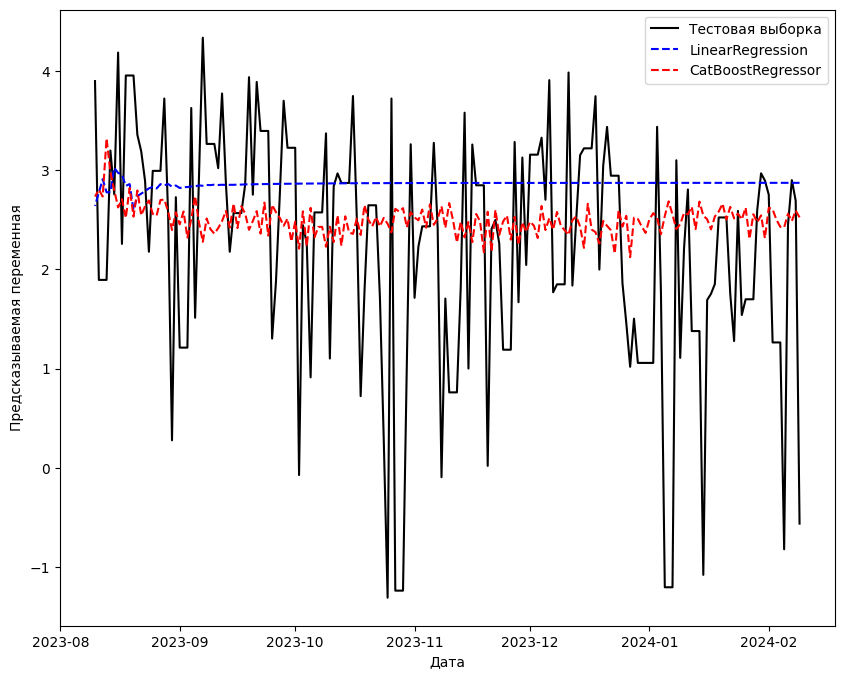

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(data_df.reset_index().datetime[-test_size:][::-1], test[::-1], label='Тестовая выборка', c='black')
ax.plot(data_df.reset_index().datetime[-test_size:][::-1], lr_predictions[::-1], label='LinearRegression', ls='--', c='blue')
ax.plot(data_df.reset_index().datetime[-test_size:][::-1], cb_predictions[::-1], label='CatBoostRegressor', ls='--', c='red')
ax.set_xlabel('Дата')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

Результат не очень радует. Используя такой прогноз, можно остаться в долгах как в шелках. :)   

_Что делать дальше?_

Нужно или рассматривать модели сложнее, или еще большее внимание уделять обработке данных.

### Fedot



Мною были прочитаны несколько статей, в которых говорилось, что для того анализа, который будет дальше, стационарность не вносит вклад в качество модели - по этой причине для удобства дальше будем работать с нестационарными, но уже предобработанными.  
_Возможно, в дальнейнешей перспективе работа будет продолжена и будут рассмотрены модели, в которых стационарность важна._

Далее будем рассматривать модели, построенные с помощью **_отечественного_** фреймворка _FEDOT_.

In [91]:
from fedot.core.data.data import InputData
from fedot.core.data.multi_modal import MultiModalData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

In [92]:
data_new.reset_index(inplace=True)

In [93]:
df = data_new.copy()

len_forecast = int(len(data_new) * 0.1)

true_values = np.array(df['CLOSE'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['TRADEDATE'], y=true_values, mode='lines', name='Тестовая выборка'))
fig.add_trace(go.Scatter(x=df['TRADEDATE'][:-len_forecast], y=train_array, mode='lines', name='Тренировочная выборка'))

fig.update_layout(title='График тренировочных и тестовых данных',
                  xaxis_title='Дата',
                  yaxis_title='Цена акций',
                  legend_title='Данные',
                  font=dict(size=15),
                  showlegend=True)

fig.update_layout(xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'))
fig.show()

In [94]:
def make_forecast(train_data, len_forecast: int, window_size: int, final_model: str = 'ridge'):
    """
    Функция прогнозирования значений во временном ряду

    :param train_data: одномерный массив numpy для обучения конвейера
    :param len_forecast: количество значений для прогнозов
    :param window_size: размер перемещаемого окна
    :param Final_model: модель в корневом узле

    :return предсказанные_значения: массив numpy, прогноз модели
    """

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast

    forecast_idx = np.arange(start_forecast, end_forecast)
    predict_input = InputData(idx=forecast_idx,
                              features=train_data,
                              target=test_array,
                              task=task,
                              data_type=DataTypesEnum.ts)

    node_lagged = PrimaryNode('lagged')
    node_lagged.parameters = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lagged])
    ridge_pipeline = Pipeline(node_ridge)

    ridge_pipeline.fit(train_input)

    predicted_output = ridge_pipeline.predict(predict_input)

    forecast = np.ravel(np.array(predicted_output.predict))

    return forecast

In [95]:
predicted_values = make_forecast(train_data=train_array,
                                 len_forecast=len_forecast,
                                 window_size=400,
                                 final_model='ridge')

In [96]:
def plot_results(actual_time_series, predicted_values, len_train_data, dates, y_name='Parameter'):
    """
    Функция построения графика с прогнозами

    :param actual_time_series: весь массив с одномерными данными
    :param predicted_values: массив с предсказанными значениями
    :param len_train_data: количество элементов в обучающей выборке
    :param dates: массив дат
    :param y_name: имя оси Y
    """

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=dates[:len(actual_time_series)], y=actual_time_series,
                             mode='lines', name='Реальные значения', line=dict(color='green')))

    fig.add_trace(go.Scatter(x=dates[len_train_data:len_train_data + len(predicted_values)],
                             y=predicted_values, mode='lines', name='Предсказанные моделью', line=dict(color='blue')))

    fig.add_shape(type='line', x0=dates[len_train_data], y0=min(actual_time_series),
                  x1=dates[len_train_data], y1=max(actual_time_series),
                  line=dict(color='black', width=1))

    fig.update_layout(title='График фактических и предсказанных значений',
                      xaxis_title='Дата',
                      yaxis_title=y_name,
                      legend_title='Данные',
                      font=dict(size=15),
                      showlegend=True)

    fig.update_layout(xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
                      yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'))
    fig.show()

In [97]:
plot_results(actual_time_series=true_values,
             predicted_values=predicted_values,
             len_train_data=len(train_array),
             dates = df.TRADEDATE,
             y_name='Стоимость акций, руб.')

print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

Mean absolute error: 1592.114


В первом приближении результат пытается улавливаливать тренды, но качество прогноза совсем удручающее:

In [98]:
rmse_f = np.sqrt(mean_squared_error(test_array, predicted_values))
print("RMSE:", rmse_f)

mape_f = mean_absolute_percentage_error(test_array, predicted_values)
print("MAPE:", mape_f)

r2_f = r2_score(test_array, predicted_values)
print("R^2:", r2_f)

RMSE: 1838.7737051438648
MAPE: 0.5234005795857004
R^2: -29.459262612312497


In [99]:
node_lagged_1 = PrimaryNode('lagged')
node_lagged_1.parameters = {'window_size': 3}
node_lagged_2 = PrimaryNode('lagged')
node_lagged_2.parameters = {'window_size': 450}

node_knnreg = SecondaryNode('knnreg', nodes_from=[node_lagged_1])
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_2])

node_final = SecondaryNode('ridge', nodes_from=[node_knnreg, node_ridge])
complex_pipeline = Pipeline(node_final)

In [100]:
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast))

train_input = InputData(idx=np.arange(0, len(train_array)),
                        features=train_array,
                        target=train_array,
                        task=task,
                        data_type=DataTypesEnum.ts)

start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast

forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_array,
                          target=None,
                          task=task,
                          data_type=DataTypesEnum.ts)

complex_pipeline.fit(train_input)

predicted_output = complex_pipeline.predict(predict_input)

predicted_values = np.ravel(np.array(predicted_output.predict))

plot_results(actual_time_series = true_values,
             predicted_values = predicted_values,
             len_train_data = len(train_array),
             dates=df.TRADEDATE,
             y_name = 'Стоимость акций, руб.')

print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

Mean absolute error: 971.641


Тренды модель улавливает, но вот со значениями - всё так же, как и раньше, печаль печальная.  
Рассмотрим еще вариант, добавим еще **один признак**, который поможет в обучении модели - ценообразование акций на момент _открытия торгов_:

In [101]:
df = data.copy()
df['OPEN_CLOSE_DIFF'] = df['OPEN'] - df['CLOSE']
df['PRICE_RANGE'] = df['HIGH'] - df['LOW']

cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95) and column != 'OPEN']

df = df.drop(cols_to_drop, axis=1)

print(df.columns)

Index(['TRADEDATE', 'CLOSE', 'OPEN', 'VALUE', 'CAPITALIZATION', 'DIVISOR',
       'OPEN_CLOSE_DIFF', 'PRICE_RANGE'],
      dtype='object')


In [102]:
fig = px.line(df, x='TRADEDATE', y=['CLOSE', 'OPEN'], title='График стоимости акций IMOEX',
              labels={'TRADEDATE': 'Дата', 'value': 'Стоимость акций, руб.'})

fig.update_layout(legend_title='Данные')

fig.show()

In [103]:
len_forecast = int(len(data_new) * 0.1)
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

true_values = np.array(df['CLOSE'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

train_lagged = InputData(idx=np.arange(0, len(train_array)),
                         features=train_array,
                         target=train_array,
                         task=task,
                         data_type=DataTypesEnum.ts)
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                           features=train_array,
                           target=test_array,
                           task=task,
                           data_type=DataTypesEnum.ts)

In [104]:
exog_arr = np.array(df['OPEN'])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]

train_exog = InputData(idx=np.arange(0, len(exog_train)),
                       features=exog_train,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)
start_forecast = len(exog_train)
end_forecast = start_forecast + len_forecast
predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                          features=exog_test,
                          target=test_array,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [105]:
train_dataset = MultiModalData({
    'lagged': train_lagged,
    'exog_ts': train_exog
})

predict_dataset = MultiModalData({
    'lagged': predict_lagged,
    'exog_ts': predict_exog
})

Создадим пайплайн с разными источниками данных в узлах:

In [106]:
node_lagged = PrimaryNode('lagged')
node_exog = PrimaryNode('exog_ts')
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged, node_exog])
exog_pipeline = Pipeline(node_ridge)

exog_pipeline.fit(train_dataset)

predicted = exog_pipeline.predict(predict_dataset)
predicted_values = np.ravel(np.array(predicted.predict))

In [107]:
plot_results(actual_time_series = true_values,
             predicted_values = predicted_values,
             dates=df.TRADEDATE,
             len_train_data = len(train_array),
             y_name = 'Стоимость акций, руб.')

print(f'Mean absolute error: {mean_absolute_error(test_array, predicted_values):.3f}')

Mean absolute error: 13.189


In [108]:
fig.write_html("./results/result_fedot_IMOEX.html")

Взглянем и на другие метрики:

In [109]:
rmse_f = np.sqrt(mean_squared_error(test_array, predicted_values))
print("RMSE:", rmse_f)

mape_f = mean_absolute_percentage_error(test_array, predicted_values)
print("MAPE:", mape_f)

r2_f = r2_score(test_array, predicted_values)
print("R^2:", r2_f)

RMSE: 16.9927612026866
MAPE: 0.00461576430936491
R^2: 0.9973986982998345


Получили добротный результат. Но насколько он реалистичен и достоверен? :)   

P.S. Наверное, если бы было всё относительно просто, все люди мира были бы при 💵💲💰:

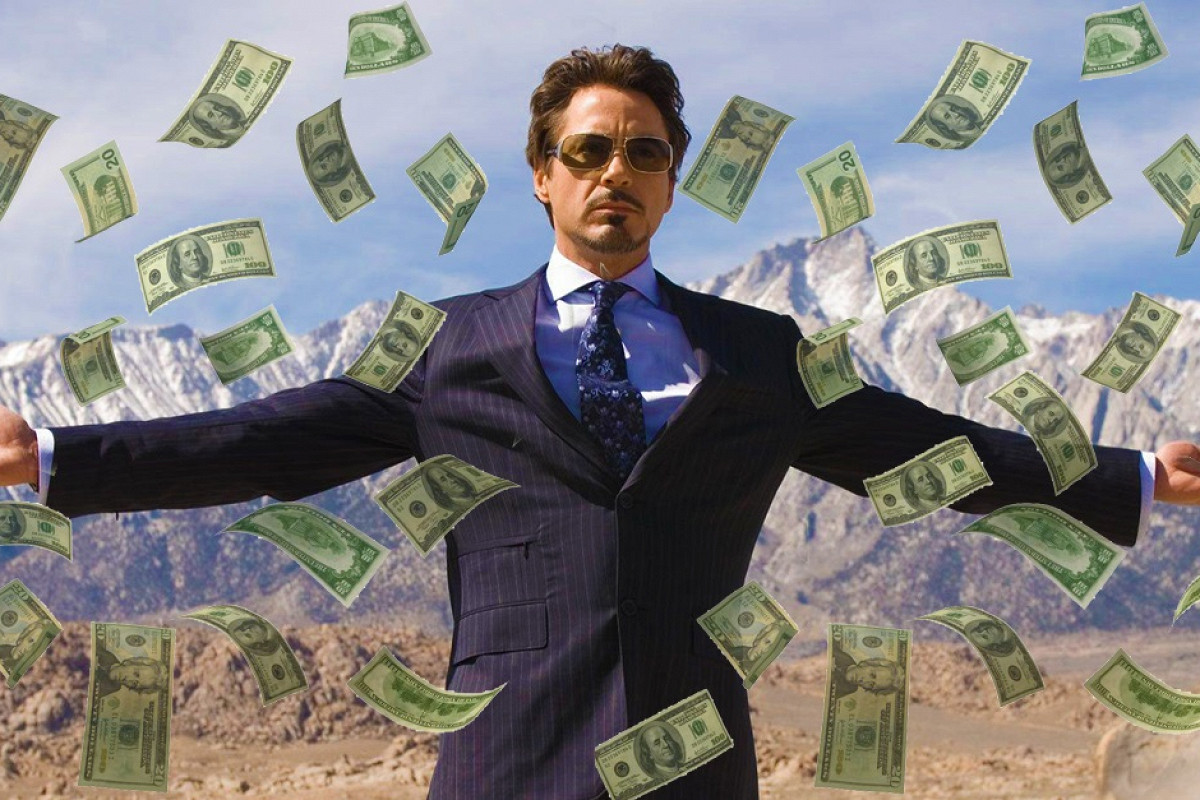

## Задание 2

В рамках данного пункта **<u>необходимо проинтерпретировать модель, полученную в предыдущем задании</u>**.

**_Критерии оценки:_**

- Получена интерпретация построенной модели, включая визуализации (коэффициенты/значения перестановок/ форма и тд) - _5б_.

- Приведено экспертное мнение о полученной интерпретации (вы, как эксперт в предметной области, можете оценить адекватность признаков и решений, принимаемых моделью, и выразить свое мнение в 1-2 предложении) - _5б_.

Мною также были построены модели, в которых, помимо целевого признака CLOSE, были `data_new['CLOSE_lag_1'] = data_new['CLOSE'].shift(1)`, `data_new['CLOSE_lag_2'] = data_new['CLOSE'].shift(2)`, `data_new['CLOSE_lag_3'] = data_new['CLOSE'].shift(3)` -- эти признаки в совокупности с основным CLOSE (без OPEN) в результате обучения модели давали близкий к 1.0 r2_score (R^2: 0.99* - погрешность в третьем знаке).   


_P.S.: Помните, что_ **ФОНДОВЫЙ РЫНОК - НЕПРЕДСКАЗУЕМ**. _Это живая экосистема, **на которую влияет <u>множество факторов**</u>._
